In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from birdclef.spark import get_spark
from pyspark.sql import functions as F
from matplotlib import pyplot as plt
from pacmap import PaCMAP
import numpy as np
from pathlib import Path

In [3]:
root = Path("~/shared/birdclef/2025").expanduser()
scratch_root = Path("~/scratch/birdclef/2025").expanduser()
spark = get_spark(cores=8, memory="20g")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/26 19:48:03 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/04/26 19:48:03 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).


In [4]:
@F.udf("array<float>")
def mean_udf(arr):
    # mean and normalize the emeddings
    y = np.mean(arr, axis=0)
    # norm = np.linalg.norm(y)
    norm = 1
    return (y / norm).astype(np.float32).tolist()


@F.udf("string")
def get_class(file):
    return Path(file).parts[-2]


def read_embeddings(spark, path):
    df = spark.read.parquet(path)
    return df.select(
        *df.columns[:3],
        F.array(*df.columns[3:]).alias("embeddings"),
    ).orderBy("file", "start_time")


def average_file_embeddings(df):
    return (
        df.groupBy("file")
        .agg(mean_udf(F.collect_list("embeddings")).alias("embeddings"))
        .orderBy("file")
    )


def average_class_embeddings(df):
    return (
        df.withColumn("class", get_class(F.col("file")))
        .groupBy("class")
        .agg(mean_udf(F.collect_list("embeddings")).alias("embeddings"))
        .orderBy("class")
    )


def plot_embeddings_pdf(pdf, title="embedding plot", col="embeddings", color=None, s=1):
    X = np.stack(pdf[col].values)
    reducer = PaCMAP(n_components=2)
    g = reducer.fit_transform(X)
    kwargs = {}
    if color is not None:
        kwargs["c"] = color
    plt.scatter(g[:, 0], g[:, 1], s=s, alpha=0.5, **kwargs)
    plt.title(title)
    plt.show()


def plot_embeddings(df, *args, **kwargs):
    plot_embeddings_pdf(df.toPandas(), *args, **kwargs)

25/04/26 19:48:11 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


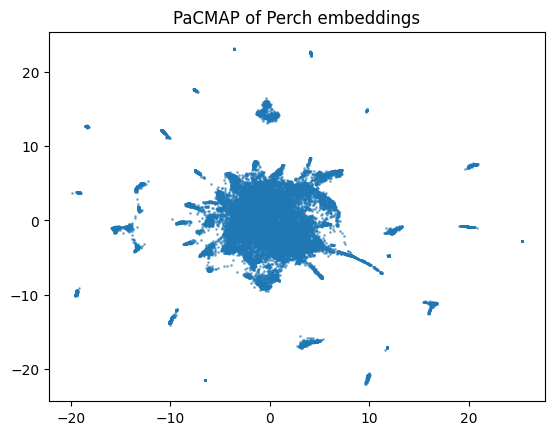

In [5]:
perch = read_embeddings(spark, f"{scratch_root}/infer-train/Perch/parts/embed")
avg_perch = average_file_embeddings(perch)
plot_embeddings(avg_perch, "PaCMAP of Perch embeddings")

In [6]:
perch.show(n=1, vertical=True, truncate=100)

-RECORD 0----------------------------------------------------------------------------------------------------------
 file       | /storage/coda1/p-dsgt_clef2025/0/shared/birdclef/raw/birdclef-2025/train_audio/1139490/CSA36385.ogg  
 start_time | 0.0                                                                                                  
 end_time   | 5.0                                                                                                  
 embeddings | [0.03518490865826607, 0.3122355341911316, -0.16324949264526367, -0.18498514592647552, 0.106910660... 
only showing top 1 row



In [7]:
df = (
    perch.withColumn("class", get_class("file"))
    .groupBy("class")
    .agg(
        F.countDistinct("file").alias("num_files"),
        F.count("*").alias("num_embeddings"),
        (F.count("*") * 5 / 60 / 60).alias("num_hours"),
    )
)
df.orderBy("num_hours", ascending=False).show(n=10)
df.orderBy("num_files", ascending=True).show(n=10)
df.summary().show()

+-------+---------+--------------+------------------+
|  class|num_files|num_embeddings|         num_hours|
+-------+---------+--------------+------------------+
| compau|      777|          6099| 8.470833333333333|
| grekis|      907|          5464| 7.588888888888889|
| roahaw|      648|          5262| 7.308333333333334|
| whtdov|      542|          4988| 6.927777777777778|
|laufal1|      456|          4853| 6.740277777777778|
| trokin|      712|          4591| 6.376388888888888|
|yercac1|      289|          4005|            5.5625|
| trsowl|      443|          3866|5.3694444444444445|
| banana|      579|          3769| 5.234722222222222|
|wbwwre1|      488|          3566| 4.952777777777778|
+-------+---------+--------------+------------------+
only showing top 10 rows



+-------+---------+--------------+--------------------+
|  class|num_files|num_embeddings|           num_hours|
+-------+---------+--------------+--------------------+
|  21116|        1|             1|0.001388888888888...|
| 548639|        2|             4|0.005555555555555555|
|  67082|        2|             8| 0.01111111111111111|
|  47067|        2|            14|0.019444444444444445|
|  66578|        2|            14|0.019444444444444445|
|1139490|        2|            38| 0.05277777777777778|
|  66531|        2|            14|0.019444444444444445|
|  41778|        2|            40| 0.05555555555555556|
|  42113|        2|             4|0.005555555555555555|
|  81930|        2|             8| 0.01111111111111111|
+-------+---------+--------------+--------------------+
only showing top 10 rows



+-------+------------------+------------------+------------------+--------------------+
|summary|             class|         num_files|    num_embeddings|           num_hours|
+-------+------------------+------------------+------------------+--------------------+
|  count|               205|               205|               205|                 205|
|   mean|317987.89830508473| 128.0487804878049| 916.2878048780487|   1.272621951219512|
| stddev|420616.46187810047|157.51780964036305|1169.0297133451668|  1.6236523796460651|
|    min|           1139490|                 1|                 1|0.001388888888888...|
|    25%|           42113.0|                17|               140| 0.19444444444444445|
|    50%|           66016.0|                74|               496|  0.6888888888888889|
|    75%|          548639.0|               171|              1208|  1.6777777777777778|
|    max|            ywcpar|               907|              6099|   8.470833333333333|
+-------+------------------+----

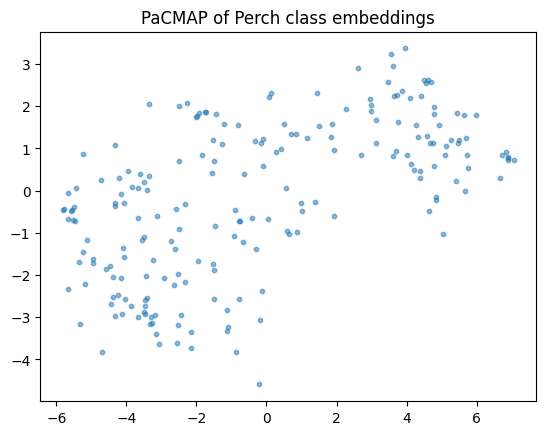

In [8]:
perch_class_avg = average_class_embeddings(perch).cache()
plot_embeddings(perch_class_avg, "PaCMAP of Perch class embeddings", s=10)

Do these classes cluster along the taxonomic tree? We have some information about the orders and stuff, so let's try to integrate this into the dataframe that we've computed.

In [9]:
taxonomy = spark.read.csv(f"{root}/../raw/birdclef-2025/taxonomy.csv", header=True)
taxonomy.show(n=10)
taxonomy.groupBy("class_name").count().show()

+-------------+-------------+--------------------+--------------------+----------+
|primary_label|inat_taxon_id|     scientific_name|         common_name|class_name|
+-------------+-------------+--------------------+--------------------+----------+
|      1139490|      1139490|Ragoniella pulchella|Ragoniella pulchella|   Insecta|
|      1192948|      1192948|Oxyprora suriname...|Oxyprora suriname...|   Insecta|
|      1194042|      1194042| Copiphora colombiae| Copiphora colombiae|   Insecta|
|       126247|       126247|Leptodactylus ins...|Spotted Foam-nest...|  Amphibia|
|      1346504|      1346504|Neoconocephalus b...|Neoconocephalus b...|   Insecta|
|       134933|       134933|Espadarana prosob...|  Emerald Glass Frog|  Amphibia|
|       135045|       135045|Andinobates opist...|  Andean Poison Frog|  Amphibia|
|      1462711|      1462711|Cocconotus aratif...|Cocconotus aratif...|   Insecta|
|      1462737|      1462737|Docidocercus fasc...|Docidocercus fasc...|   Insecta|
|   

+-------+--------------------+-------------+--------------------+--------------------+----------+-----+
|  class|          embeddings|inat_taxon_id|     scientific_name|         common_name|class_name|color|
+-------+--------------------+-------------+--------------------+--------------------+----------+-----+
|1139490|[-0.024502797, -0...|      1139490|Ragoniella pulchella|Ragoniella pulchella|   Insecta|    2|
|1192948|[-0.015756411, -0...|      1192948|Oxyprora suriname...|Oxyprora suriname...|   Insecta|    2|
|1194042|[0.008595397, -0....|      1194042| Copiphora colombiae| Copiphora colombiae|   Insecta|    2|
| 126247|[0.13330649, 0.01...|       126247|Leptodactylus ins...|Spotted Foam-nest...|  Amphibia|    1|
|1346504|[0.036889166, -0....|      1346504|Neoconocephalus b...|Neoconocephalus b...|   Insecta|    2|
+-------+--------------------+-------------+--------------------+--------------------+----------+-----+
only showing top 5 rows



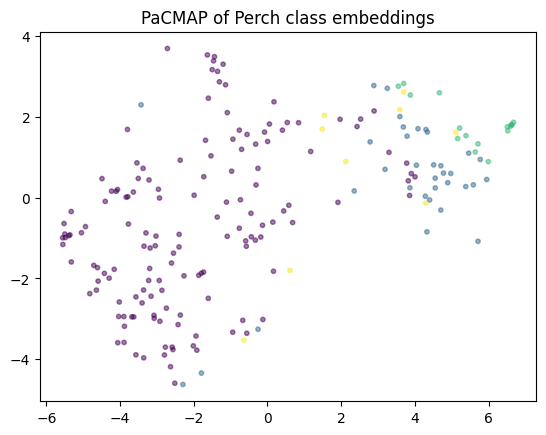

In [10]:
mapper = {
    "Aves": 0,
    "Amphibia": 1,
    "Insecta": 2,
    "Mammalia": 3,
}
df = (
    perch_class_avg.join(
        taxonomy.withColumnRenamed("primary_label", "class"),
        on="class",
    )
    .orderBy("class")
    .withColumn("color", F.udf(lambda x: mapper[x], "int")("class_name"))
)
df.show(n=5)
pdf = df.toPandas()

plot_embeddings_pdf(pdf, "PaCMAP of Perch class embeddings", s=10, color=pdf.color)

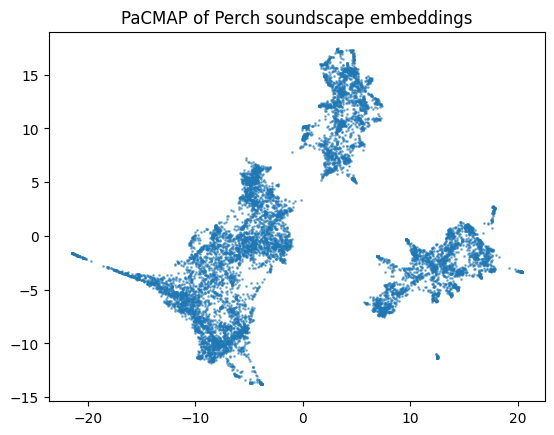

In [11]:
# let's plot species prototypes vs soundscapes

soundscapes = read_embeddings(spark, f"{root}/infer-soundscape/Perch/parts/embed")
avg_soundscape = average_file_embeddings(soundscapes)
plot_embeddings(avg_soundscape, "PaCMAP of Perch soundscape embeddings", s=1)

In [12]:
# join the two dataframes together, and then have a class column for which one it belongs to

df = (
    avg_soundscape.select(
        F.col("file").alias("id"),
        "embeddings",
        F.lit("soundscape").alias("class_name"),
        F.lit(1).alias("is_soundscape"),
    )
    .union(
        perch_class_avg.select(
            F.col("class").alias("id"),
            "embeddings",
            F.lit("prototype").alias("class_name"),
            F.lit(0).alias("is_soundscape"),
        )
    )
    .orderBy("id")
)
df.show(n=3)

+--------------------+--------------------+----------+-------------+
|                  id|          embeddings|class_name|is_soundscape|
+--------------------+--------------------+----------+-------------+
|/storage/coda1/p-...|[-0.009288231, 0....|soundscape|            1|
|/storage/coda1/p-...|[-0.054256704, 0....|soundscape|            1|
|/storage/coda1/p-...|[-0.018681884, 0....|soundscape|            1|
+--------------------+--------------------+----------+-------------+
only showing top 3 rows



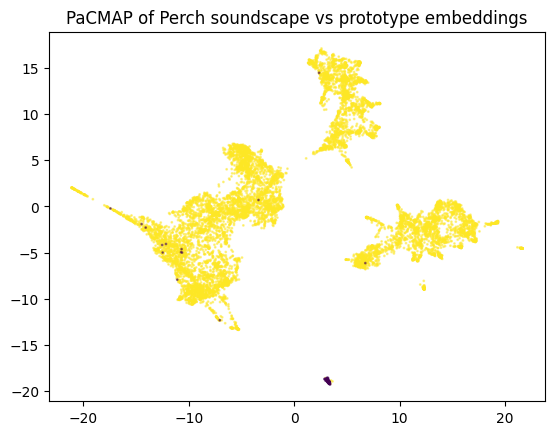

In [13]:
plot_embeddings(
    df,
    "PaCMAP of Perch soundscape vs prototype embeddings",
    s=1,
    color=df.select("is_soundscape").toPandas().is_soundscape.values,
)